In [1]:
"""
This code list implement the Monte Carlo Policy Gradient Alogrithm.
------------------------------------------------------------------
Input:
    differentiable policy function $\pi_{\theta}(a|s)$

Initalize:
    Parameter $\theta$ for policy function

Repeat  experience trajectory:
    Use $\pi_{\theta}(a|s)$ to generate one trajectory $(s_0,a_0,r_1....s_T)$
    Repeat each step in trajectory:
        G <--- cumlated reward at time step t
        Calculate the policy gradient  $\Delta\theta_t = \alpha \Delta_{\theta}log\pi_{\theta}(s_t, a_t)G_t$
------------------------------------------------------------------
"""
import time
import pandas as pd
import gym
import os 
import sys
import numpy as np
import tensorflow as tf
from collections import defaultdict, namedtuple

import matplotlib
from matplotlib import pyplot as plt


In [2]:
RENDER_ENV = False
LEARNING_RATE = 0.02
REWARD_DECAY = 0.99
OUTPUT_GRAPH = False
ENVNAME = "CartPole-v0"
N_LAYER1 = 10
N_LAYER2 = 10
NUM_EPISODES = 400
ACTIVATION_FUNCTION = tf.nn.tanh

In [3]:
class MCPG():
    def __init__(self, 
                 n_action, 
                 n_feature, 
                 learning_rate=0.01, 
                 reward_decay=0.95, 
                 ouput_graph=False,
                ):
        self.n_action = n_action
        self.n_features = n_feature
        self.gamma = reward_decay
        self.learning_rate = learning_rate
        
        self.episode_observation = []
        self.episode_actions = [] 
        self.episode_rewards = []
        
        self.__build_network()
        self.sess = tf.Session()
        if ouput_graph:
            # $ tensorboard --logdir=logs
            # http://0.0.0.0:6006/
            tf.summary.FileWriter("logs/", self.sess.graph)            
        
        self.sess.run(tf.global_variables_initializer())
        
    def __build_network(self):
        with tf.name_scope("inputs"):
            # input
            self.tf_observations = tf.placeholder(tf.float32, 
                                                  [None, self.n_features],
                                                  name='observation') 
            self.tf_acts = tf.placeholder(tf.int32,
                                          [None,],
                                          name='action_number')
            self.tf_actionvalue = tf.placeholder(tf.float32,
                                                [None,],
                                                name = "action_value")
        l1 = tf.layers.dense(
            inputs=self.tf_observations,
            units=N_LAYER1,
            activation= ACTIVATION_FUNCTION,
            kernel_initializer=tf.random_normal_initializer(mean=0, stddev=0.3),
            bias_initializer=tf.constant_initializer(0.1),
            name="layer1"
        )
        
        l2 = tf.layers.dense(
            inputs=l1,
            units=N_LAYER2,
            activation= ACTIVATION_FUNCTION,
            kernel_initializer=tf.random_normal_initializer(mean=0, stddev=0.3),
            bias_initializer=tf.constant_initializer(0.1),
            name="layer2"
        )
        
        all_action_value = tf.layers.dense(
            inputs=l2,
            units=self.n_action,
            activation= None,
            kernel_initializer=tf.random_normal_initializer(mean=0, stddev=0.3),
            bias_initializer=tf.constant_initializer(0.1),
            name="layer3"
        )
        
        self.all_action_prob = tf.nn.softmax(all_action_value, name="action_prob")
                
        with tf.name_scope('loss'):
            #  to maximize total reward  (log_p * R) is 
            #  to minimize -(log_p * R), and the tensorflow only have minimize(loss)
            # sparse_softmax_cross_entropy_with_logits is negative log of chosen action
            # or in this way:
            # neg_log_prob = tf.reduce_sum(-tf.log(self.all_act_prob)\
            #                *tf.one_hot(self.tf_acts, self.n_actions), axis=1)
            neg_log_prob = tf.nn.sparse_softmax_cross_entropy_with_logits(
                logits=all_action_value, labels=self.tf_acts)
            # calcuate the loss
            loss = tf.reduce_mean(neg_log_prob*self.tf_actionvalue)
        with tf.name_scope('train'):
            self._train_op = tf.train.AdamOptimizer(self.learning_rate).minimize(loss)    
                        
    def choose_action(self, observation):
        feed_state = observation[np.newaxis,:]
        prob_weights = self.sess.run(self.all_action_prob,
                                    feed_dict={self.tf_observations:feed_state})
        action = np.random.choice(range(prob_weights.shape[1]),
                                 p=prob_weights.ravel())
        return action
    
    def store_transistion(self, s, a, r):
        self.episode_observation.append(s)
        self.episode_actions.append(a)
        self.episode_rewards.append(r)

    def learn(self):
        #discount and normalize the episode reward
        discounted_episode_reward_normalized = self._discount_and_norm_rewards()
        
        # train
        self.sess.run(self._train_op,
                     feed_dict={
                         self.tf_observations : np.vstack(self.episode_observation),
                         self.tf_acts : np.array(self.episode_actions),
                         self.tf_actionvalue: discounted_episode_reward_normalized,
                     })
        self.episode_observation = []
        self.episode_actions = [] 
        self.episode_rewards = []
        return discounted_episode_reward_normalized
    
    def _discount_and_norm_rewards(self):
        discounted_episode_reward = np.zeros_like(self.episode_rewards)
        running_add = 0
        for t in reversed(range(0, len(self.episode_rewards))):
            running_add = running_add * self.gamma + self.episode_rewards[t]
            discounted_episode_reward[t] = running_add
        
        # normalized
        discounted_episode_reward -= np.mean(discounted_episode_reward)
        discounted_episode_reward /= np.std(discounted_episode_reward)
        return discounted_episode_reward        

In [4]:
def plot_episode_stats1(rec, xlabel, ylabel,title):
    fig = plt.figure(figsize=(20, 10), facecolor = "white")
    ax = fig.add_subplot(111)
    ax.plot(rec) 
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    return fig

def plot_episode_stats2(stats):
    # Plot time steps and episode number
    fig3 = plt.figure(figsize=(20, 10))
    plt.plot(np.cumsum(stats.episode_lengths), np.arange(len(stats.episode_lengths)))
    plt.xlabel("Time Steps")
    plt.ylabel("Episode")
    plt.title("Episode per time step")
    return fig3

def Plot_the_result(rec):
    # Plot episode length over time
    episode_lengths = rec.episode_lengths
    fig = plot_episode_stats1(episode_lengths, 
                       xlabel = "Episode",
                       ylabel = "Episode Length",
                       title = "Episode length over Time"
            )
    fig.show()
    fig.savefig("./log/MCPG_keras_CartPole_EpisodeLength.jpg")

    # Plot Episode reward over time
    smoohing_window = 10
    reward_smooths = pd.Series(rec.episode_rewards).rolling(smoohing_window,\
                    min_periods = smoohing_window).mean()
    fig = plot_episode_stats1(reward_smooths, 
                       xlabel = "Episode",
                       ylabel = "Episode Reward",
                       title = "Episode reward over time"
            )
    fig.show()
    fig.savefig("./log/MCPG_keras_CartPole_EpisodeReward.jpg")
    
    # Plot Episode per time step
    fig = plot_episode_stats2(rec)
    fig.show()
    fig.savefig("./log/MCPG_keras_CartPole_EpisodePerTimeStep.jpg")

In [5]:
def update(RL, env, num_episodes):
    # Track the statistics of the result
    record = namedtuple("Record", ["episode_lengths","episode_rewards"])
    
    rec = record(episode_lengths=np.zeros(num_episodes),
                          episode_rewards=np.zeros(num_episodes))
    
    for i_episode in range(num_episodes):
        if 0 == (i_episode +1) % 1:
            print("This the episode {}/{}".format(i_episode, num_episodes), end = "\r")
        observation = env.reset()
        step =0
        reward_cum = 0
        done = False
        while True:
            #env.render()
            if RENDER_ENV:
                env.render()
            # step1: choose action based on the state
            action = RL.choose_action(observation)
            # step2: take the action in the enviroment
            observation_next, reward, done, info = env.step(action)
            # step3: store the transistion for training
            RL.store_transistion(observation, action, reward)
            # update the record
            step += 1
            rec.episode_lengths[i_episode] = step 
            rec.episode_rewards[i_episode] += reward
            if done or rec.episode_rewards[i_episode] > 3000:
                # step4: train the network
                RL.learn()
                print("The reward at episode {} is {}.".format(i_episode, 
                                                              rec.episode_rewards[i_episode]))
                break
            # step5: save the new state
            observation = observation_next
    print("Finished")
    env.close()
    return rec

Instructions for updating:
Use keras.layers.dense instead.
The reward at episode 0 is 20.0.
The reward at episode 1 is 14.0.
The reward at episode 2 is 24.0.
The reward at episode 3 is 12.0.
The reward at episode 4 is 34.0.
The reward at episode 5 is 114.0.
The reward at episode 6 is 18.0.
The reward at episode 7 is 99.0.
The reward at episode 8 is 66.0.
The reward at episode 9 is 84.0.
The reward at episode 10 is 81.0.
The reward at episode 11 is 45.0.
The reward at episode 12 is 39.0.
The reward at episode 13 is 53.0.
The reward at episode 14 is 48.0.
The reward at episode 15 is 38.0.
The reward at episode 16 is 24.0.
The reward at episode 17 is 50.0.
The reward at episode 18 is 21.0.
The reward at episode 19 is 26.0.
The reward at episode 20 is 19.0.
The reward at episode 21 is 26.0.
The reward at episode 22 is 21.0.
The reward at episode 23 is 24.0.
The reward at episode 24 is 18.0.
The reward at episode 25 is 18.0.
The reward at episode 26 is 27.0.
The reward at episode 27 is 15.0

The reward at episode 150 is 88.0.
The reward at episode 151 is 64.0.
The reward at episode 152 is 70.0.
The reward at episode 153 is 67.0.
The reward at episode 154 is 71.0.
The reward at episode 155 is 87.0.
The reward at episode 156 is 74.0.
The reward at episode 157 is 89.0.
The reward at episode 158 is 71.0.
The reward at episode 159 is 63.0.
The reward at episode 160 is 87.0.
The reward at episode 161 is 133.0.
The reward at episode 162 is 115.0.
The reward at episode 163 is 67.0.
The reward at episode 164 is 159.0.
The reward at episode 165 is 115.0.
The reward at episode 166 is 161.0.
The reward at episode 167 is 99.0.
The reward at episode 168 is 94.0.
The reward at episode 169 is 69.0.
The reward at episode 170 is 79.0.
The reward at episode 171 is 80.0.
The reward at episode 172 is 267.0.
The reward at episode 173 is 72.0.
The reward at episode 174 is 77.0.
The reward at episode 175 is 87.0.
The reward at episode 176 is 61.0.
The reward at episode 177 is 54.0.
The reward at 

/home/jabes/.local/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/jabes/.local/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/jabes/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


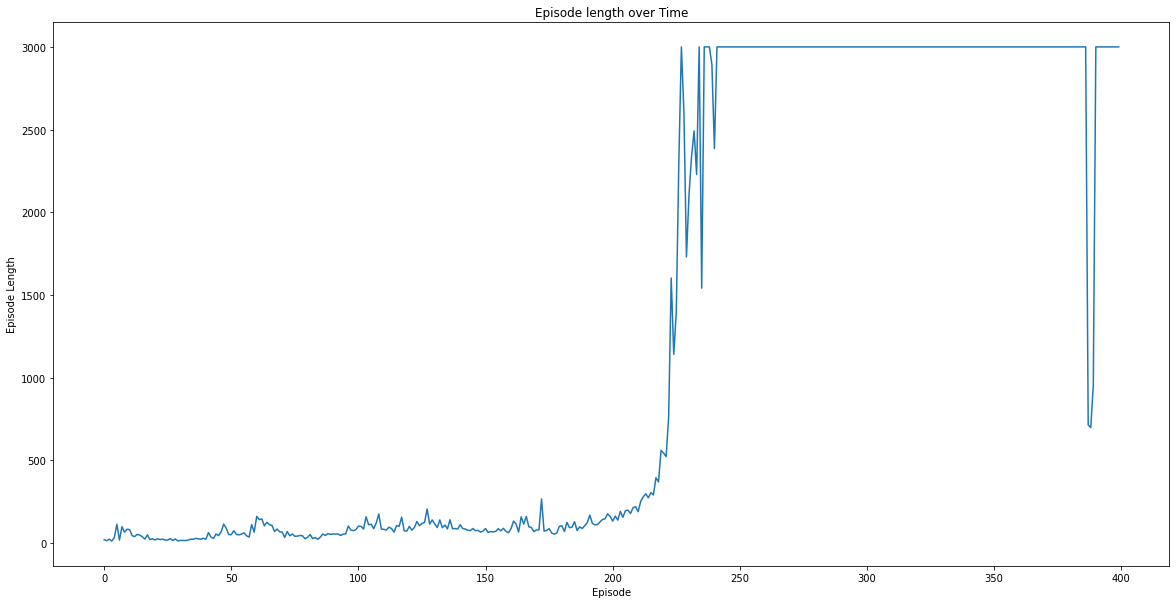

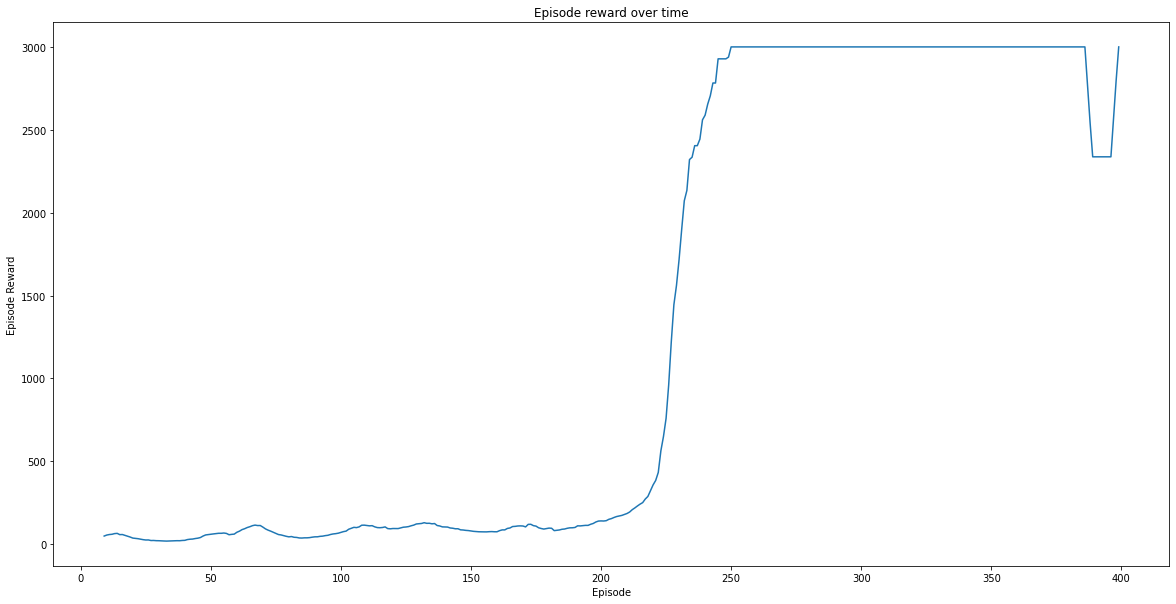

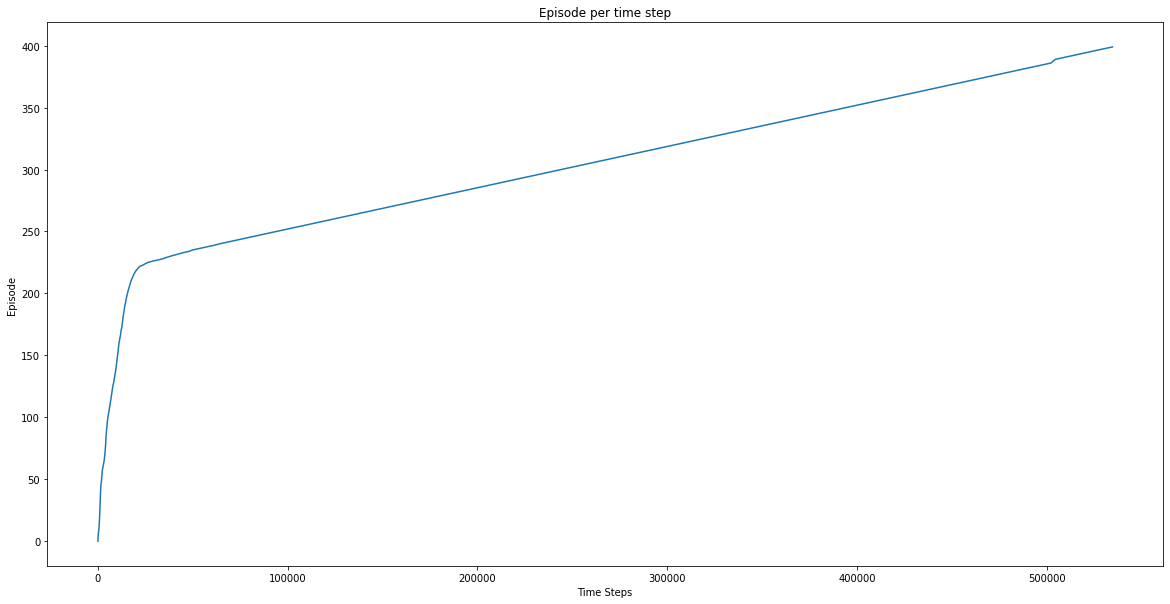

In [6]:
if __name__ == "__main__":
    env = gym.make(ENVNAME)
    env = env.unwrapped
    RL = MCPG(n_action=env.action_space.n,
             n_feature=env.observation_space.shape[0],
             learning_rate=LEARNING_RATE,
             reward_decay=REWARD_DECAY,
             ouput_graph=OUTPUT_GRAPH)
    rec = update(RL, env, num_episodes=NUM_EPISODES)
    #Plot the result
    Plot_the_result(rec)